In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

In [2]:
import pandas as pd
df = pd.read_csv('../../dataset_files/drug_dataset.csv')
df = pd.DataFrame(df)
df['title']

0                       Why is this medication prescribed?
1                        How should this medicine be used?
2                             Other uses for this medicine
3                What special precautions should I follow?
4        What special dietary instructions should I fol...
                               ...                        
17738                What other information should I know?
17739                                          Brand names
17740                        In case of emergency/overdose
17741                What other information should I know?
17742                                          Brand names
Name: title, Length: 17743, dtype: object

In [3]:
titles = set(df['title'].str.lower())
sentences = list(titles)
len(sentences)

136

In [4]:
model = SentenceTransformer('paraphrase-mpnet-base-v2')

In [5]:
sentence_embeddings = model.encode(sentences)

In [6]:
# sentence_embeddings[0]
sentence_embeddings.shape

(136, 768)

In [7]:
# Hyperparameter 1 
n_dimention = 10
pca = PCA(n_components=n_dimention)
reduced_data = pca.fit_transform(sentence_embeddings)

In [8]:
reduced_data.shape

(136, 10)

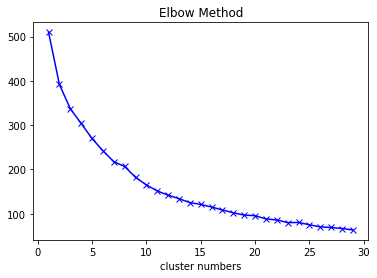

In [9]:
SSE = []

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(reduced_data)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 30), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [10]:
# Hyperparameter 2
n_clusters = 10

km = KMeans(n_clusters=n_clusters)

km.fit(reduced_data)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  10  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 'deprecated', 'precompute_distances': 'deprecated', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [11]:
len(centers[0])

10

In [12]:
test_cases = random.sample(range(0, len(sentences) - 1), 30)

In [13]:
for i in test_cases:
    print(sentences[i], km.predict(reduced_data[i].reshape(-1, 1).T))

what are the risks of the janssen (johnson and johnson) vaccine? [6]
chickenpox vaccine [2]
who should not get td vaccine or should wait? [3]
notice: [5]
where can i report cases of suspected fraud? [5]
what is meningococcal disease? [7]
shingles vaccine (recombinant) [2]
what is the countermeasures injury compensation program [5]
important warning:  [5]
who should not get je vaccine or should wait? [3]
cholera vaccine [2]
who should not get meningococcal group b vaccine or should wait? [3]
what is live, attenuated influenza vaccine-laiv (nasal spray)? [2]
what should i do if i forget a dose? [8]
brand names [4]
who should not get meningococcal vaccine or should wait? [3]
what are the risks of a vaccine reaction? [6]
brand names of combination products [4]
what special precautions should i follow? [5]
what if there is a moderate or severe problem? [1]
what is yellow fever? [2]
who should get yellow fever vaccine? [3]
what is hib vaccine? [2]
what is japanese encephalitis? [2]
what shou

In [14]:
# Hyperparameter 1 
n_dimention = 10
tsne = TSNE(n_components=n_dimention, method='exact')
reduced_data = tsne.fit_transform(sentence_embeddings)

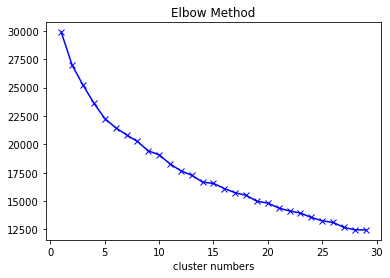

In [15]:
SSE = []

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(reduced_data)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 30), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [16]:
# Hyperparameter 2
n_clusters = 10

km = KMeans(n_clusters=n_clusters)

km.fit(reduced_data)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  10  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 'deprecated', 'precompute_distances': 'deprecated', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [17]:
for i in test_cases:
    print(sentences[i], km.predict(reduced_data[i].reshape(-1, 1).T))

what are the risks of the janssen (johnson and johnson) vaccine? [9]
chickenpox vaccine [0]
who should not get td vaccine or should wait? [5]
notice: [6]
where can i report cases of suspected fraud? [6]
what is meningococcal disease? [1]
shingles vaccine (recombinant) [7]
what is the countermeasures injury compensation program [7]
important warning:  [8]
who should not get je vaccine or should wait? [8]
cholera vaccine [4]
who should not get meningococcal group b vaccine or should wait? [1]
what is live, attenuated influenza vaccine-laiv (nasal spray)? [8]
what should i do if i forget a dose? [1]
brand names [2]
who should not get meningococcal vaccine or should wait? [4]
what are the risks of a vaccine reaction? [6]
brand names of combination products [5]
what special precautions should i follow? [8]
what if there is a moderate or severe problem? [9]
what is yellow fever? [6]
who should get yellow fever vaccine? [8]
what is hib vaccine? [0]
what is japanese encephalitis? [1]
what shou

In [18]:
# Hyperparameter 1 
# Barnes–Hut method works only with less than 4 dimensions
n_dimention = 3
tsne = TSNE(n_components=n_dimention, method='barnes_hut')
reduced_data = tsne.fit_transform(sentence_embeddings)

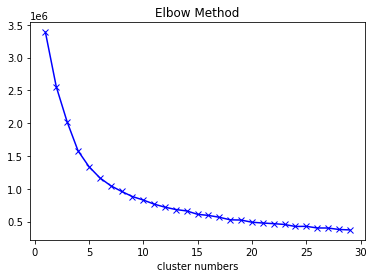

In [19]:
SSE = []

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(reduced_data)
    SSE.append(kmeans.inertia_)
    
plt.plot(range(1, 30), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.show()

In [20]:
# Hyperparameter 2
n_clusters = 5

km = KMeans(n_clusters=n_clusters)

km.fit(reduced_data)
centers = km.cluster_centers_.argsort()[:,::-1]

print("Len of Labels: ",
       len(set(km.labels_)), 
       " Params: ", 
       km.get_params())

Len of Labels:  5  Params:  {'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 'deprecated', 'precompute_distances': 'deprecated', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [21]:
for i in test_cases:
    print(sentences[i], km.predict(reduced_data[i].reshape(-1, 1).T))

what are the risks of the janssen (johnson and johnson) vaccine? [1]
chickenpox vaccine [0]
who should not get td vaccine or should wait? [2]
notice: [3]
where can i report cases of suspected fraud? [3]
what is meningococcal disease? [0]
shingles vaccine (recombinant) [2]
what is the countermeasures injury compensation program [0]
important warning:  [2]
who should not get je vaccine or should wait? [3]
cholera vaccine [1]
who should not get meningococcal group b vaccine or should wait? [4]
what is live, attenuated influenza vaccine-laiv (nasal spray)? [4]
what should i do if i forget a dose? [4]
brand names [0]
who should not get meningococcal vaccine or should wait? [4]
what are the risks of a vaccine reaction? [0]
brand names of combination products [1]
what special precautions should i follow? [2]
what if there is a moderate or severe problem? [2]
what is yellow fever? [0]
who should get yellow fever vaccine? [1]
what is hib vaccine? [4]
what is japanese encephalitis? [0]
what shou